In [2]:
# LSTM MODEL EVALUATION
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc as sklearn_auc
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import torch
from collections import Counter
import joblib 
import os

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Base Parameters
WINDOW = 30  # frames
STRIDE = 10   # next window step
K_CONSEC_FALL = 8  # consecutive frames to alert
K_CONSEC_ATT = 5
CONFIG = "lstm"
CONFIG_LABEL = f"{WINDOW}_s{STRIDE}_kf{K_CONSEC_FALL}_ka{K_CONSEC_ATT}"
# Parameters
NUM_CLASSES = 3
OUTPUT_BASE_PATH = "results/fall_detect_yolo11n_pose_balanced"
OUTPUT_DATASET_DIR = f"{OUTPUT_BASE_PATH}/windows_{CONFIG_LABEL}/"
OUTPUT_LSTM_MODEL_DIR = f"{OUTPUT_BASE_PATH}/lstm_model_w{CONFIG_LABEL}_{CONFIG}"
OUTPUT_LSTM_MODEL_FULL = "lstm_model_full.keras"
OUTPUT_LSTM_MODEL_BEST = "lstm_model_best.keras"
OUTPUT_LSTM_MODEL_HISTORY = "lstm_model_history.json"

with open(f"{OUTPUT_LSTM_MODEL_DIR}/{OUTPUT_LSTM_MODEL_HISTORY}", "r") as f:
    history = json.load(f)

history = dict(history)

In [8]:
# Class counting in train and val
X_train = np.load(f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split/X_train.npy")
X_val = np.load(f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split/X_val.npy")
y_train = np.load(f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split/y_train.npy")
y_val = np.load(f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split/y_val.npy")

#print(X_train.argmax(axis=1))
#print(X_val.argmax(axis=1))

train_counts = Counter(y_train.argmax(axis=1))
val_counts = Counter(y_val.argmax(axis=1))
print(f"Distribuição y_train:", train_counts)
print(f"Distribuição y_val:", val_counts)

# Load Scaler
print("\nLoading and applying StandardScaler to validation data...")
scaler_path = f"{OUTPUT_LSTM_MODEL_DIR}/train_test_split/scaler.joblib"
scaler = joblib.load(scaler_path)

# Reshape, apply the scaler and reshape back to 3D
nsamples_val, nframes_val, nfeatures_val = X_val.shape
X_val_reshaped = X_val.reshape((nsamples_val * nframes_val, nfeatures_val))
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled_reshaped.reshape(nsamples_val, nframes_val, nfeatures_val)

print("Validation data ready for model evaluation.")

Distribuição y_train: Counter({0: 4946, 1: 1709, 2: 706})
Distribuição y_val: Counter({0: 1237, 1: 427, 2: 177})

Loading and applying StandardScaler to validation data...
Validation data ready for model evaluation.


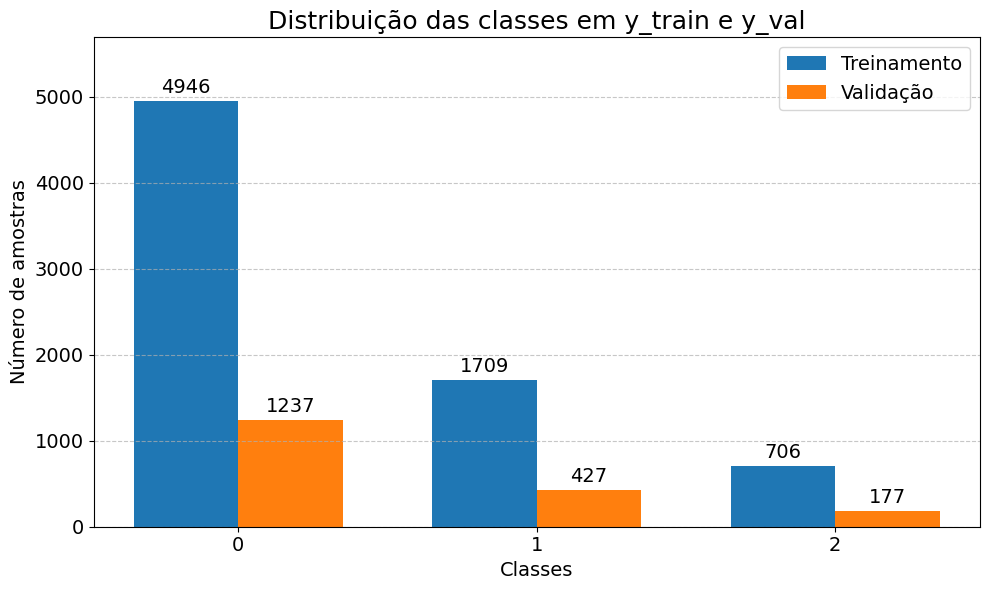

In [28]:
labels = sorted(set(train_counts.keys()) | set(val_counts.keys()))

train_vals = [train_counts.get(lbl, 0) for lbl in labels]
val_vals = [val_counts.get(lbl, 0) for lbl in labels]

x = np.arange(len(labels))  # positions
width = 0.35  # bar size

plt.figure(figsize=(10,6))
bars_train = plt.bar(x - width/2, train_vals, width, label="Treinamento")
bars_val = plt.bar(x + width/2, val_vals, width, label="Validação")

def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 pontos de deslocamento vertical
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=14)

# Chamar a função para os dois conjuntos de barras
add_bar_labels(bars_train)
add_bar_labels(bars_val)

plt.xlabel("Classes", fontsize=14)
plt.ylabel("Número de amostras", fontsize=14)
plt.title("Distribuição das classes em y_train e y_val", fontsize=18)
plt.xticks(x, labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, max(train_vals + val_vals) * 1.15) 
plt.legend(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/class_distribution2.png", dpi=300)
plt.show()

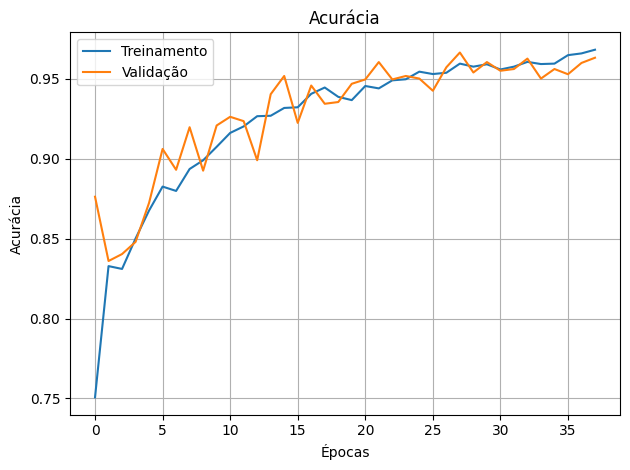

In [46]:
# Accuracy
plt.plot(history['accuracy'], label='Treinamento')
plt.plot(history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/accuracy.png", dpi=300)
plt.show()

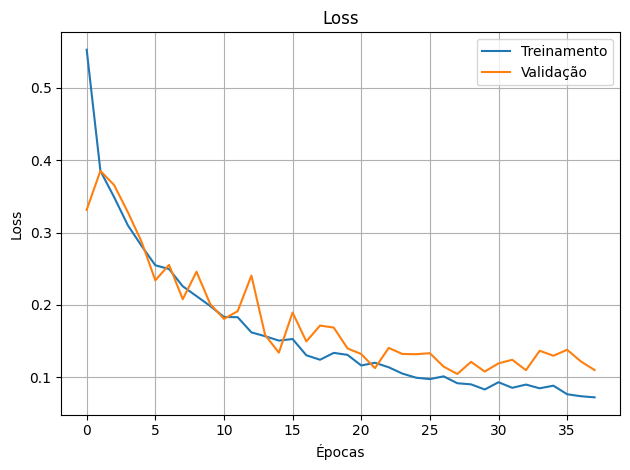

In [48]:
# Loss
plt.plot(history['loss'], label='Treinamento')
plt.plot(history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/loss.png", dpi=300)
plt.show()

In [50]:
# Model evaluation
lstm_model = load_model(f"{OUTPUT_LSTM_MODEL_DIR}/{OUTPUT_LSTM_MODEL_BEST}")

loss, acc = lstm_model.evaluate(X_val_scaled, y_val)
print(f"\n Avaliação - Loss: {loss:.4f}, Acurácia: {acc:.4f}\n")

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9632 - loss: 0.1300

 Avaliação - Loss: 0.1048, Acurácia: 0.9663



In [54]:
# Model shape
print(f"Input shape: {lstm_model.input_shape}")
print(f"Output shape: {lstm_model.output_shape}") # saida com 3 neuronios (para 3 classes
print(f"Parameters qty: {lstm_model.count_params()}")

Input shape: (None, 30, 128)
Output shape: (None, 3)
Parameters qty: 61923


In [56]:
# Model summary
lstm_model.summary()

# Para verificar a primeira camada LSTM (índice 0)
print("Configuração da primeira camada LSTM:")
print(lstm_model.layers[0].get_config())

# Para verificar a segunda camada LSTM (índice 1)
print("\nConfiguração da segunda camada LSTM:")
print(lstm_model.layers[1].get_config())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,771 (725.67 KB)

 Trainable params: 61,923 (241.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 123,848 (483.79 KB)

Configuração da primeira camada LSTM:
{'name': 'lstm_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurren

In [58]:
# Prediction
y_pred = lstm_model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred_classes, target_names=["no_fall", "fall", "attention"]))

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

     no_fall       0.98      0.97      0.98      1237
        fall       0.98      0.97      0.98       427
   attention       0.83      0.92      0.87       177

    accuracy                           0.97      1841
   macro avg       0.93      0.95      0.94      1841
weighted avg       0.97      0.97      0.97      1841



In [60]:
# Area Under the Curve / ROC Curve (Receiver Operating Characteristic)
for i, class_name in enumerate(["no_fall", "fall", "attention"]):
    auc = roc_auc_score(y_val[:, i], y_pred[:, i])
    print(f"AUC {class_name}: {auc:.4f}")

AUC no_fall: 0.9929
AUC fall: 0.9993
AUC attention: 0.9843


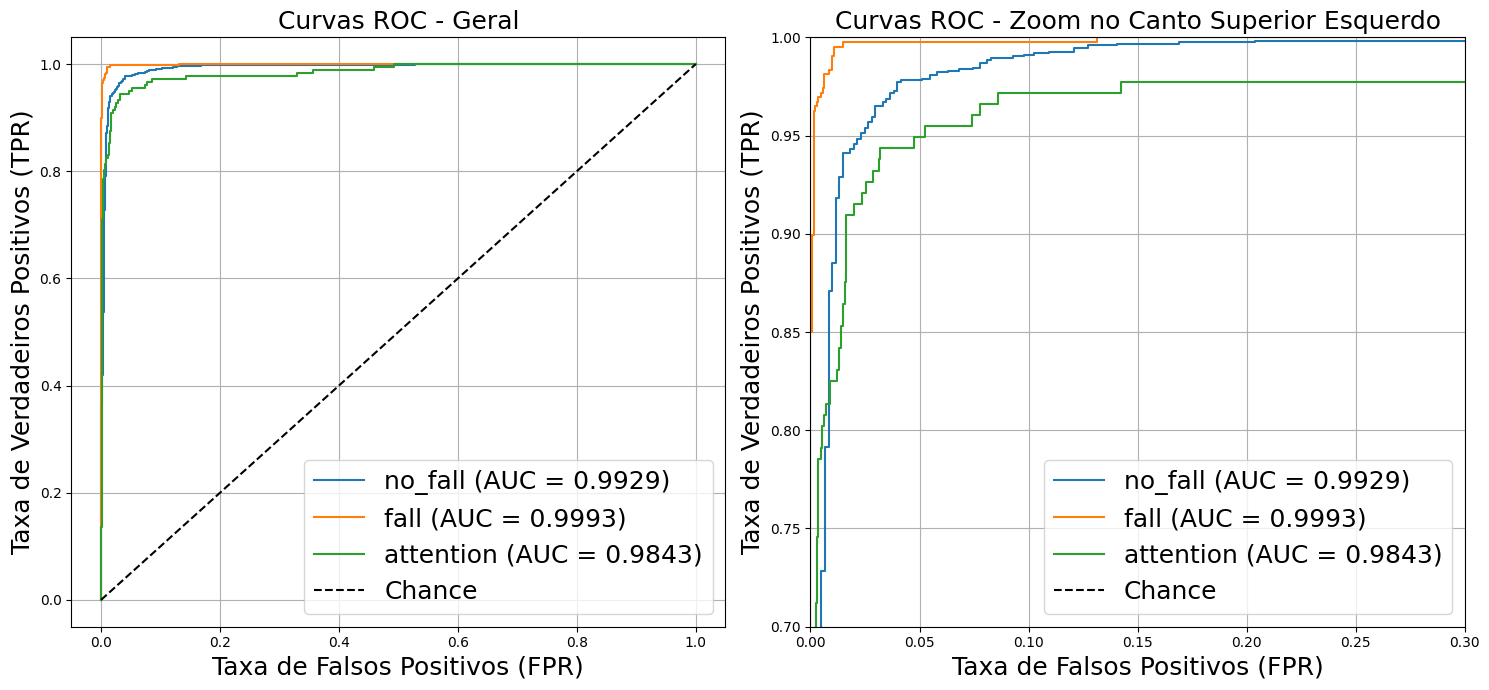

In [64]:
# ROC Curve
# With y_val and y_pred in one-hot format and probablities
class_names = ["no_fall", "fall", "attention"]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc = sklearn_auc(fpr, tpr)

    # Plot geral
    axes[0].plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.4f})")
    
    # Plot com zoom
    axes[1].plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.4f})")

# --- Configurando o gráfico Geral (axes[0]) ---
axes[0].plot([0, 1], [0, 1], 'k--', label='Chance') # Linha de chance
axes[0].set_title('Curvas ROC - Geral', fontsize=18)
axes[0].set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=18)
axes[0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=18)
axes[0].legend(loc='lower right', fontsize=18)
axes[0].grid(True)

# --- Configurando o gráfico com Zoom (axes[1]) ---
axes[1].plot([0, 1], [0, 1], 'k--', label='Chance') # Linha de chance
axes[1].set_title('Curvas ROC - Zoom no Canto Superior Esquerdo', fontsize=18)
axes[1].set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=18)
axes[1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=18)

# Aplicando os limites de zoom APENAS no segundo gráfico
axes[1].set_xlim([0.0, 0.3])
axes[1].set_ylim([0.7, 1.0]) 
axes[1].legend(loc='lower right', fontsize=18)
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/roc_curve.png", dpi=300)
plt.show()

#plt.plot([0, 1], [0, 1], 'k--')  # linha de chance
#plt.xlabel('FPR (False Positive Rate)')
#plt.ylabel('TPR (True Positive Rate)')
#plt.legend(loc='lower right')
#plt.grid(True)

# Títulos
#axes[0].set_title('Curvas ROC - Geral')
#axes[1].set_title('Curvas ROC - Zoom')

#plt.xlim([0.0, 0.1])   # limita FPR de 0 a 0.1
#plt.ylim([0.7, 1.0])   # limita TPR de 0.9 a 1.0
#plt.tight_layout()
#plt.show()

Matriz de Confusão:


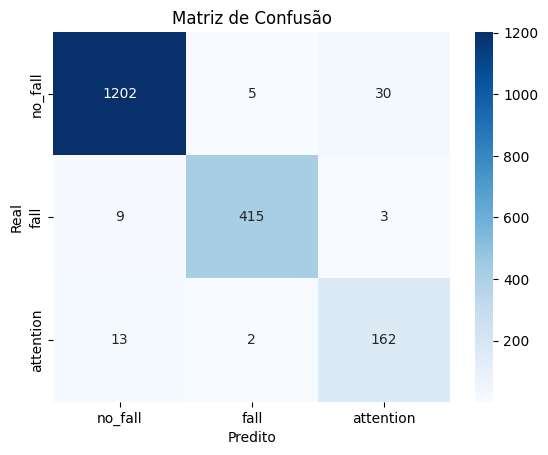

In [66]:
# Confusion Matrix
print("Matriz de Confusão:")
cm = confusion_matrix(y_true, y_pred_classes)
labels = ["no_fall", "fall", "attention"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.savefig(f"{OUTPUT_LSTM_MODEL_DIR}/confusion_matrix.png", dpi=300)
plt.show()